# Analysis of the Australian Bushfires (2019 - 2020)

In this notebook we will conduct an analysis of the 2019 - 2020 Australia Wildfire impacts. The bush fires are estimated to have burned about 24.3 million hectares (60 million acres), impacting the local fauna and flora. Our analysis will further dive into the impacts of the wildfire on the landcover and evapotranspiration of Australia.

### Authors
- Michael Zargari, UC Santa Barbara (mzargari@ucsb.edu) 
- Dalila Lara, UC Santa Barbara (dalilalara@ucsb.edu) 
- Ruth Enriquez, UC Santa Barbara (rbe786@ucsb.edu) 

## Table of Contents

[1. Purpose](#purpose)

[2. Dataset Description](#overview)

[3. Data I/O](#io)

[4. Metadata Display and Basic Visualization](#display)

[5. Use Case Examples](#usecases)

[6. Create Binder Environment](#binder)

[7. References](#references)

<a id='purpose'></a> 
## Notebook Purpose

This notebook contains a walkthrough of our analysis of two datasets. The first dataset that we are looking at is FireCCI51: MODIS Fire_cci Burned Area Pixel Product, Version 5.1 dataset which contains data of burned areas over the continent of Australia from 2001 - 2020. And the seond dataset we are looking at is Actual Evapotranspiration for Australia (CRMSET Landsat V2.2). We are conducting this analysis to assess the impact of the 2019 - 2020 Australian bushfire season, known as the Black Summer.


<img src="fire.png"
     alt="FIREEEEEEEEEEEEEEEEE"
     style="float: left; margin-right: 10px;" />
<center> <caption> Wildfire impacts on fauna </caption> </center>

<a id='overview'></a> 
## Dataset Description

This portion of the notebook contains a summary description of the datasets we use in our analysis.

In this Jupyter Notebook we are looking at two datasets, our first one being the FireCCI51: MODIS Fire_cci Burned Area Pixel Product, Version 5.1 dataset, and our second one being the Actual Evapotranspiration for Australia (CMRSET Landsat V2.2) dataset.

- The creators of our dataset: 

The creators of our first dataset (MODIS Fire_cci Burned Area Pixel Product, Version 5.1) is the European Space Agency (ESA) Climate Change Initiative (CCI) Programme. MODIS stands Moderate Resolution Imaging Spectroradiometer. Although the satellite MODIS was launched by NASA in 2001,  the dataset available via Google Earth Engine by the ESA.

The second dataset (Actual Evapotranspiration for Australia (CMRSET Landsat V2.2)) is provided by TERN Landscapes and CSIRO Land and Water. TERN stands for Terrestrial Ecosystem Research Network which is an Austrailian Government NCRIS (National Collaborative Research Infrastructure Strategy) enabled project. CSIRO (Commonwealth Scientific and Industrial Research Organisation) is an Australian Government corporate entity that conducts scientific research.

- Major characteristics of our dataset: 

Our first dataset contains information on burned area on a monthly global ~250m spatial resolution. The dataset uses surface reflectance in the Near Infrared (NIR) band from the MODIS instrument onboard the Terra satellite launched by NASA, as well as active fire information from the same sensor of the Terra and Aqua satellites.

This dataset includes the estimated day of the first detection of the fire, the confidence level of that detection, and the land cover that has been burned for each pixel. In addition, an observation flag is provided to identify the pixels that were not processed due to the lack of valid observations or because they belong to a non-burnable land cover. We only looked at the burned areas within the dataset and did not utilize the observation flag variable.

The second dataset contains information about Actual EvapoTranspirations otherwise known as AET or ETa. Scientist used the CSIRO MODIS Relfectance-based Scaling EvapoTranspiration or CMRSET algorithm to calculate ETa by combining data from five remote sensors at different spatial resolutions and temporal frequencies:

Spatial resolutions:
1. 500 m, MODIS, VIIRS
2. 30 m, Landsat
3. 20 m, Sentinel-2

Temporal frequencies:

4. Daily, MODIS, VIIRS
5. Multi-days, Landsat, Sentinel-2


- The file format(s) used to store the data:

The first dataset is in GeoTiff format ussing the CRS World Geodetic System (WGS84) and uses the Plate Carrée projection. 

The second dataset is in GeoTiff format as well. 

- The source/archive you will be using to retrieve the data: 
We are accessing both datasets via Google Earth Engine using the Earth Engine Snippet. 

- Any known issues with data quality that might be expected to impact the results:

There are two issues that we noticed regarding the first dataset quality. First is that it was noted that there are pixels that could not be processed because of the lack of quality data or because the pixels show land that cannot be burned in the first place (i.e. water). Secondly, the data stops at the end of 2020. This hinders our ability to track land and vegetation recovery rates into the future.

Regarding the second dataset quality, the formatting of the dates are not in the standarized ISO date format. Hence we manipulated the dates entered as milimeter per day into the ISO format allowing us to further work with the data. In addition, the data does not specify the color pallete Evapotranspiration values.


- Links to our Data:

<a href="https://developers.google.com/earth-engine/datasets/catalog/ESA_CCI_FireCCI_5_1#dois" >MODIS Fire_cci Burned Area Pixel Product, Version 5.1 </a>

<a href = "https://developers.google.com/earth-engine/datasets/catalog/TERN_AET_CMRSET_LANDSAT_V2_2"> Actual Evapotranspiration for Australia (CMRSET Landsat V2.2) </a>



<img src="map.png"
     alt="Map"
     style="float: left; margin-right: 10px;" />
<center><caption> 2019 - 2020 Australia Wildfire Map </caption> </center>

<a id='io'></a> 
## Dataset Input/Output 

In [24]:
## Importing packages 
import ee
import geemap
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cartopy
import cartopy.crs as ccrs
from geemap import cartoee

In [25]:
## Authenticate and initialize GEE
#ee.Authenticate()
ee.Initialize()

In [26]:
## Reading in the burned area data
burned_area = ee.ImageCollection("ESA/CCI/FireCCI/5_1") 
burned_area

In [27]:
## Specifiying area of interest Australia
lon = 133.94366873677208
lat = -31.14574060196506

## Set the scale and our point of interest (Australia)
poi = ee.Geometry.Point(lon, lat)
scale = 100000 #scale in m

<a id='display'></a> 
## Metadata Display and Basic Visualization

In [28]:
### Exploring the data 

## Pulling test img 
test = burned_area.first()

## Pulling info for test image (columns)
bands=test.bandNames()
str(bands.getInfo())

"['BurnDate', 'ConfidenceLevel', 'LandCover', 'ObservedFlag']"

In [29]:
### Exploring the data and seeing bands 

## Pulling Land Cover from data
region = burned_area.select("LandCover")
ts = region.getRegion(poi, scale).getInfo()

## Transforming the ts into a data frame 
df_australia = pd.DataFrame(ts)

## Assign the first entry in the data frame to a variable called "headers"
headers=df_australia.loc[0]
# print(headers) # Look at headers

## New data frame with headers as column names 
df = pd.DataFrame(df_australia.values[1:], columns=headers)     # Make a new data frame out of the old one, but assigning the names we just retrieved as actual column headers

## Double checking that the headers are now columns 
# print(df)    

## Now manipulating time column 
df['datetime'] = pd.to_datetime(df['time'], unit='ms')
df

,id,longitude,latitude,time,LandCover,datetime
0,2001_01_01,134.298135,-30.991877,978307200000,None,2001-01-01
1,2001_02_01,134.298135,-30.991877,980985600000,None,2001-02-01
2,2001_03_01,134.298135,-30.991877,983404800000,None,2001-03-01
3,2001_04_01,134.298135,-30.991877,986083200000,None,2001-04-01
4,2001_05_01,134.298135,-30.991877,988675200000,None,2001-05-01
...,...,...,...,...,...,...
235,2020_08_01,134.298135,-30.991877,1596240000000,None,2020-08-01
236,2020_09_01,134.298135,-30.991877,1598918400000,None,2020-09-01
237,2020_10_01,134.298135,-30.991877,1601510400000,None,2020-10-01
238,2020_11_01,134.298135,-30.991877,1604188800000,None,2020-11-01


## Making GEE maps of Australia LandCover before and during the 2019 Wildfire 

### Before Wildfire (January 2015 - December 2018)

In [30]:
## Defining Visualization parameters
visParams = {'bands': ['LandCover'],
             'min': 1,
             'max': 366,
             'palette': ['ff0000', 'fd4100', 'fb8200', 'f9c400', 'f2ff00', 'b6ff05',
                         '7aff0a', '3eff0f', '02ff15', '00ff55', '00ff99', '00ffdd',
                         '00ddff', '0098ff', '0052ff', '0210ff', '3a0dfb', '7209f6',
                         'a905f1', 'e102ed', 'ff00cc', 'ff0089', 'ff0047', 'ff0004'],
              'opacity':  0.7

            }

## Define parameters for GEE base map
# lon = 133.94366873677208
# lat = -31.14574060196506

map_before_f = geemap.Map(center=[-31, 145], zoom=4)

## Command to extract all data over appropriate time, perform Land Cover avg
## 2015 - 2018 Avg of landcover 
t_before_f=burned_area.filter(ee.Filter.date('2015-01-01', '2018-12-30'))

In [31]:
## Creating a legend using the band colors as defined in metadata

landcover_legend = {
    "Cropland, rainfed" : "ffff64",
    "Cropland, irrigated or post-flooding" : "aaf0f0",
    "Mosaic cropland (>50%) / natural vegetation (tree, shrub, herbaceous cover) (<50%)" : "dcf064",
    "Mosaic natural vegetation (tree, shrub, herbaceous cover) (>50%) / cropland (<50%)" : "c8c864",
    "Tree cover, broadleaved, evergreen, closed to open (>15%)" : "6400",
    "Tree cover, broadleaved, deciduous, closed to open (>15%)" : "00a000",
    "Tree cover, needleleaved, evergreen, closed to open (>15%)" : "003c00",
    "Tree cover, needleleaved, deciduous, closed to open (>15%)" : "285000",
    "Tree cover, mixed leaf type (broadleaved and needleleaved)" : "788200",
    "Mosaic tree and shrub (>50%) / herbaceous cover (<50%)" : "8ca000",
    "Mosaic herbaceous cover (>50%) / tree and shrub (<50%)" : "be9600",
    "Shrubland" : "966400",
    "Grassland" : "ffb432",
    "Lichens and mosses" : "ffdcd2",
    "Sparse vegetation (tree, shrub, herbaceous cover) (<15%)" : "ffebaf",
    "Tree cover, flooded, saline water" : "9678",
    "Shrub or herbaceous cover, flooded, fresh/saline/brakish water" : "00dc82",
}

## Add layer to the basemap
map_before_f.addLayer(t_before_f, visParams)

## Add a legend to the map
map_before_f.add_legend(legend_title = "Landcover Legend", legend_dict = landcover_legend)


In [32]:
## Draw map
map_before_f

Map(center=[-31, 145], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

The map above is Australia's land cover before the wildfire, specifically the map is the land cover from January 2015 - December 2018. As we can observe, Australia's northern landcover is primarily composed of broadleaved deciduous trees (brighter green). Throughout the country, there are also patches of cropland which we will see later on are additional hotspots for the wildfires.

### During Wildfire (June 2019 - May 2020)

In [33]:

    
# Visualization parameters
visParams = {'bands': ['LandCover'],
             'min': 1,
             'max': 366,
             'palette': ['ff0000', 'fd4100', 'fb8200', 'f9c400', 'f2ff00', 'b6ff05',
                         '7aff0a', '3eff0f', '02ff15', '00ff55', '00ff99', '00ffdd',
                         '00ddff', '0098ff', '0052ff', '0210ff', '3a0dfb', '7209f6',
                         'a905f1', 'e102ed', 'ff00cc', 'ff0089', 'ff0047', 'ff0004'],
             'opacity':  0.7
            }

map_during_f = geemap.Map(center=[-31, 145], zoom=4)

## Command to extract all data over appropriate time, perform Land Cover avg
    ## June 2019 - May 2020 Avg of landcover 
t_during_f=burned_area.filter(ee.Filter.date('2019-06-01', '2020-05-30'))

In [34]:
### Creating a legend using the band colors as defined in metadata
landcover_legend = {
    "Cropland, rainfed" : "ffff64",
    "Cropland, irrigated or post-flooding" : "aaf0f0",
    "Mosaic cropland (>50%) / natural vegetation (tree, shrub, herbaceous cover) (<50%)" : "dcf064",
    "Mosaic natural vegetation (tree, shrub, herbaceous cover) (>50%) / cropland (<50%)" : "c8c864",
    "Tree cover, broadleaved, evergreen, closed to open (>15%)" : "6400",
    "Tree cover, broadleaved, deciduous, closed to open (>15%)" : "00a000",
    "Tree cover, needleleaved, evergreen, closed to open (>15%)" : "003c00",
    "Tree cover, needleleaved, deciduous, closed to open (>15%)" : "285000",
    "Tree cover, mixed leaf type (broadleaved and needleleaved)" : "788200",
    "Mosaic tree and shrub (>50%) / herbaceous cover (<50%)" : "8ca000",
    "Mosaic herbaceous cover (>50%) / tree and shrub (<50%)" : "be9600",
    "Shrubland" : "966400",
    "Grassland" : "ffb432",
    "Lichens and mosses" : "ffdcd2",
    "Sparse vegetation (tree, shrub, herbaceous cover) (<15%)" : "ffebaf",
    "Tree cover, flooded, saline water" : "9678",
    "Shrub or herbaceous cover, flooded, fresh/saline/brakish water" : "00dc82",
}

# Add layer to the basemap
map_during_f.addLayer(t_during_f, visParams)

map_during_f.add_legend(legend_title="Landcover Legend", legend_dict=landcover_legend)

In [35]:
# Draw map
map_during_f

Map(center=[-31, 145], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

The map above is Australia's land cover during the wildfire that took from June 2019 to May 2020. We can rapidly identify that the natural vegetation (light green) was significantly lost during this wildfire. In addition, the sensors seem to pick up new land cover in the south east that we found peculiar. We would recommend professional interpretation for this when applying findings to specific use case examples. 

Comparing these two graphs shows us the stark contrast between the vegetation that existed before the wildfires and their destruction afterwards.

<a id='usecases'></a> 
## Use Case Examples

### 1) Audience

<b> These datasets can be used for a wide range of case examples. The target users can range from farmers and environmental agencies to even the entire world. These results can be displayed at conferences such as the worldwide COP meetings and at fire mitigation summits. For example, California can use this data to see how the fires have damaged the Austrailian terrain and how the land continues to recover from this trauma. <b>

<b> In our case, we have chosen to compare the land burn areas with an evapotranspiration dataset to show the decrease of moisture evaporation from vegetation as the land lost its rich flora. <b>

### 2) Date Range

<b> We filtered out data into two date ranges: before the wildfire (January 2015 - December 2018) and during the wildfire (June 2019 - May 2020). We outputted the graphs for both datasets for each of these time ranges and then overlayed them to show the stark contrast between these two periods. <i> Our land cover data extends until December 1st of 2020 so we are unable to look beyond this date to see the future impacts of the fire and specific land recovery. We chose to stick to the wildfire season dates for this reason.<i> <b>

### 3) Results

<b> From our results, we can clearly see that the Austrailian Bushfires left a large scar in the Austrailian terrain. The two time periods show a large amount of land being scorched and left lifeless. Evapotranspiration largely decreased and floral composition of the area grew dry.<b>

<b> We could further continue our analysis if we were able to obtain a greater date range into the future. For example, if we continued to collect data, we would be able to then look at how the land recovers from the fires! If we also had more frequent data, we could see how the land recovers multiple times throughout the day rather than looking at it all daily.<b>

## Use Case Examples Data Work

In [36]:
### Reading in Evapotranspiration for Australia
et = ee.ImageCollection("TERN/AET/CMRSET_LANDSAT_V2_2")
et

In [37]:
### Exploring the data for et

## pulling test img 
test_et = et.first()

## pulling info for test image (columns)
et_bands = test_et.bandNames()
str(et_bands.getInfo())

"['ETa', 'pixel_qa']"

### Fixing Date Format and Plotting Timeseries

In [38]:
#### Exploring the data and seeing bands 

## Pulling Land Cover from data
et_region = et.select("ETa")
et_ts = et_region.getRegion(poi, scale).getInfo()

## Transforming the et_ts into a data frame 
et_df_australia = pd.DataFrame(et_ts)

## Assign the first entry in the data frame to a variable called "headers"
et_headers = et_df_australia.loc[0] 
print(et_headers) # Look at headers

## New data frame with headers as column names 
et_df = pd.DataFrame(et_df_australia.values[1:], columns = et_headers)     # Make a new data frame out of the old one, but assigning the names we just retrieved as actual column headers

## double checking that the headers are now columns 
print(et_df)    

## now manipulating time column 
et_df['date'] = pd.to_datetime(et_df['id'], format = "%Y_%d_%m")
et_df

0           id
1    longitude
2     latitude
3         time
4          ETa
Name: 0, dtype: object
0            id   longitude   latitude           time       ETa
0    2000_02_01  134.298135 -30.991877   949363200000  0.673877
1    2000_03_01  134.298135 -30.991877   951868800000  0.540017
2    2000_04_01  134.298135 -30.991877   954547200000  0.571822
3    2000_05_01  134.298135 -30.991877   957139200000  0.364262
4    2000_06_01  134.298135 -30.991877   959817600000  0.255632
..          ...         ...        ...            ...       ...
266  2022_04_01  134.298135 -30.991877  1648771200000  0.501027
267  2022_05_01  134.298135 -30.991877  1651363200000  0.407171
268  2022_06_01  134.298135 -30.991877  1654041600000  0.316519
269  2022_07_01  134.298135 -30.991877  1656633600000  0.316472
270  2022_08_01  134.298135 -30.991877  1659312000000   0.37151

[271 rows x 5 columns]


,id,longitude,latitude,time,ETa,date
0,2000_02_01,134.298135,-30.991877,949363200000,0.673877,2000-01-02
1,2000_03_01,134.298135,-30.991877,951868800000,0.540017,2000-01-03
2,2000_04_01,134.298135,-30.991877,954547200000,0.571822,2000-01-04
3,2000_05_01,134.298135,-30.991877,957139200000,0.364262,2000-01-05
4,2000_06_01,134.298135,-30.991877,959817600000,0.255632,2000-01-06
...,...,...,...,...,...,...
266,2022_04_01,134.298135,-30.991877,1648771200000,0.501027,2022-01-04
267,2022_05_01,134.298135,-30.991877,1651363200000,0.407171,2022-01-05
268,2022_06_01,134.298135,-30.991877,1654041600000,0.316519,2022-01-06
269,2022_07_01,134.298135,-30.991877,1656633600000,0.316472,2022-01-07


In [39]:
## Exploring Evapotranspiration Data further 

# Before Wildfire 
b_df = et_df[(et_df['date'] > '2015-01-01') & (et_df['date'] < '2018-12-30')]

# During Wildfire 
d_df = et_df[(et_df['date'] > '2019-06-01') & (et_df['date'] < '2020-05-30')]

([], [])

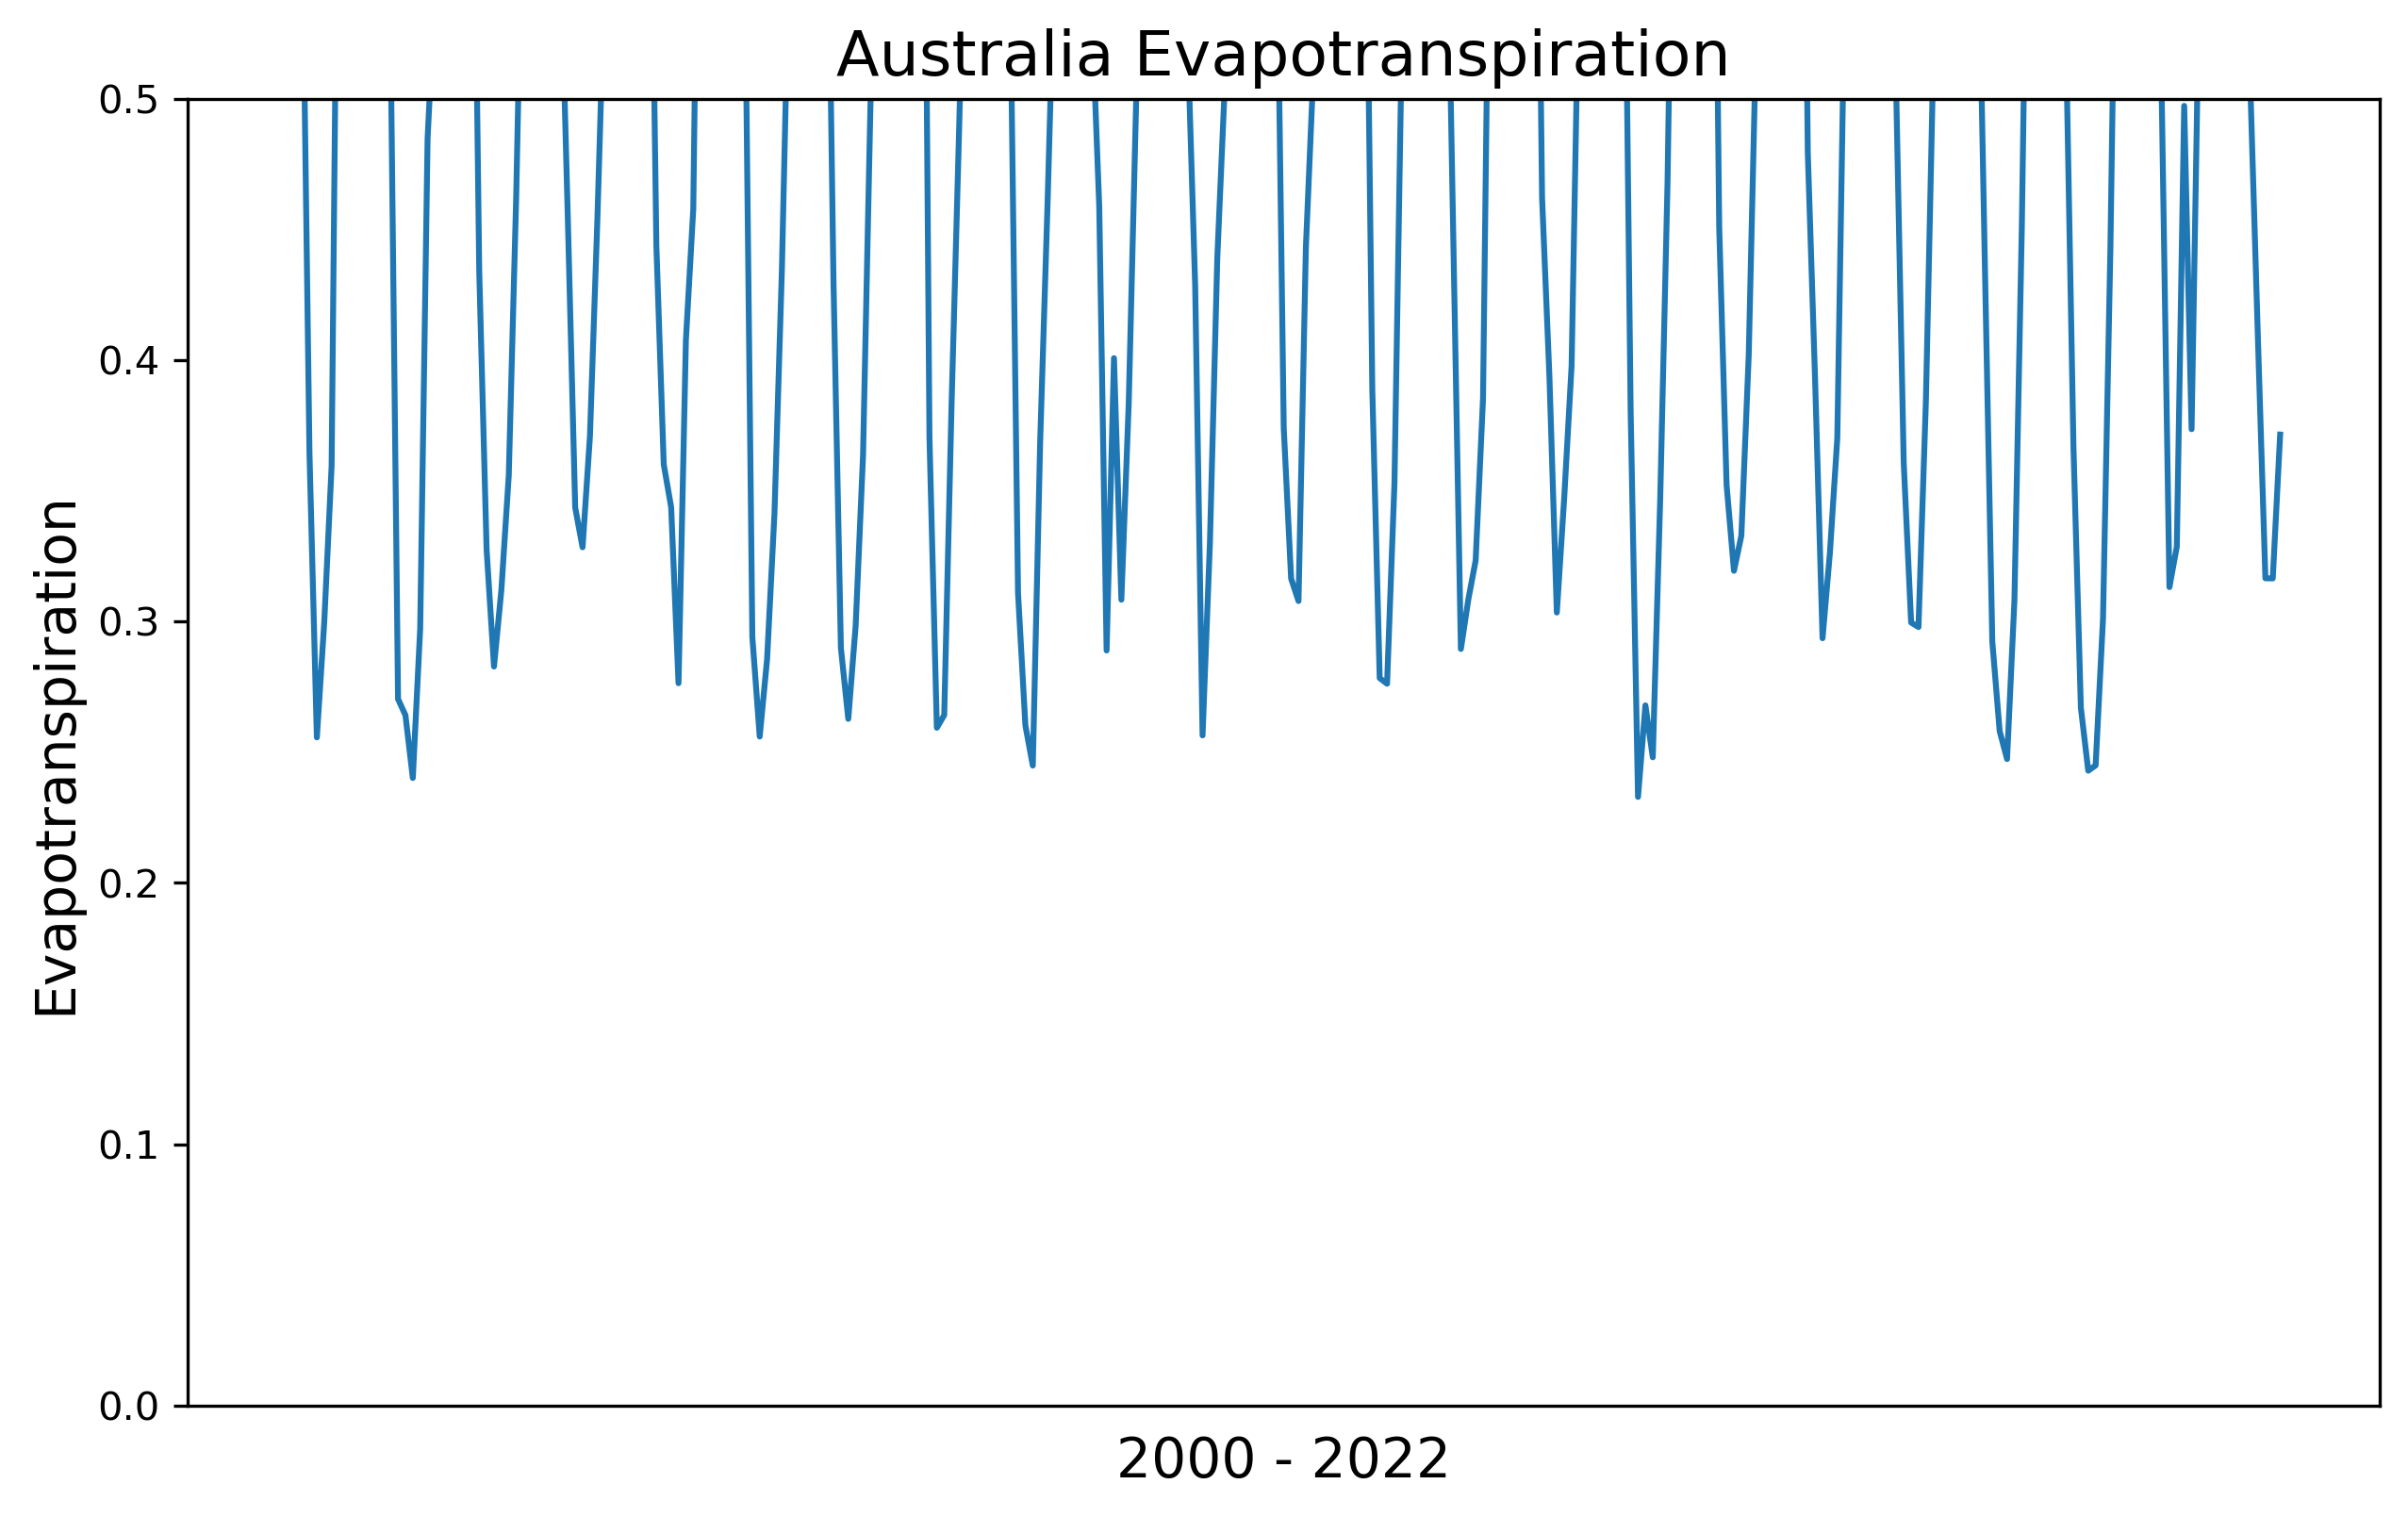

In [40]:
### plotting the evapotranspiration data  
plt.figure(figsize=(10, 6), dpi=300)    ## create a new figure, set size and resolution (dpi)
plt.plot(et_df['id'],et_df['ETa'])      ## add data to the plot
plt.title('Australia Evapotranspiration', fontsize=16)
plt.xlabel('2000 - 2022', fontsize=14)
plt.ylabel('Evapotranspiration', fontsize=14)
plt.ylim(0, 0.5)
plt.xticks([]) 

The plot above is representative of evapotranspiration in Australia from 2000 - 2022. We conducted this basic visualization to assess any significant trends or events. We can see that our time series data does not indicate any significant difference in evapotranspiration as the evapotranspirtation trends are over the entire country. For this reason, we concluded our time series data is not an effective measure to assess this data trend. Maps are more indicitive of the differences in the terrain.


####### Therefore allowing us to note that their were no significant trends, some seasonality although nothing significant for the most part. We can note that towards the end 2019 - 2020 we observe a significant downward trend in evapotranspiration levels due to the wildfire.

## Making Evapotranspiration Maps of Australian Land Cover Before and During the 2019-2020 Wildfire

### Before Wildfire (January 2015 - December 2018)

Our data did not have an available legend for what the different hex colors specifically represent, however, from our research and the provided hex colors within the metadata, we were able to discuss a rough legend for the map.

Our given visParams started from a minimum evapotranspiration of 0 millimeters per day which indicates land with no evapotranspiration to a maximum evapotranspiration value of 7 millimeters per day which indicates large bodies of water as these areas have a much larger evaporation footprint. 

<b> To interpret, our hex colors are listed in the following order: <b>

<i> d7191c (dark red) - indicates 0 mm/day of evapotranspiration
<br>fdae66 (light orange)
<br>ffffbf (light yellow)
<br>abd9e9 (light blue)
<br>2c7bb6 (dark blue) - indicates >=7 mm/day of evapotranspiration <i>

The darker red and orange values indicate lower levels of evapotranspiration, the lighter orange and yellow colors indicate larger evapotranspiration values that are indicative of forests and large swaths of nature, and blue and dark blue values indicate much larger evapotranspiration values to notate bodies of water. As the amount of evapotranspiration increases, the less red/orange the our map becomes and vice versa

In [41]:
## Visualization parameters
visParams2 = {'bands': ['ETa'],
             'min': 0,
             'max': 7,
             'palette': ['d7191c', 'fdae61', 'ffffbf', 'abd9e9', '2c7bb6']
            }

et_map_before_fire = geemap.Map(center=[-31, 133], zoom=4)

## Command to extract all data over appropriate time, perform Land Cover avg
## 2015 - 2018 Avg of landcover 
et_before_fire = et.filter(ee.Filter.date('2015-01-01', '2018-12-30'));

## Add layer to the basemap
et_map_before_fire.addLayer(et_before_fire, visParams2)

## Draw map
et_map_before_fire

Map(center=[-31, 133], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

The above map shows the evapotranspiration trends before the wildfires across Australia from January 2015 - December 2018 which is before the Australian wildfires. Overall, Australia is not an intense dark red. There are some areas that are darker but generally, the country is orange to light yellow.

There are areas of dark blue near the Great Australian Bight, south of country, which outline the water bodies. These bodies expectedly produce a large amount of evapotranspiration. 

Areas near the coastline are also lighter showing that there is more evapotranspiration from the surrounding seas in those areas compared to areas that are more inland.

Finally, the areas that are inland that are yellow or light orange most likely indicate larger forests and swaths of flora which give off much more evapotranspiration. As we will see, the wildfires greatly burn off and reduce the evapotranspiration coming from these areas.

### During Wildfire (June 2019 - May 2020)

In [44]:
## Visualization parameters
visParams2 = {'bands': ['ETa'],
             'min': 0,
             'max': 7,
             'palette': ['d7191c', 'fdae61', 'ffffbf', 'abd9e9', '2c7bb6']
            }

et_map_during_fire = geemap.Map(center=[-31, 133], zoom=4)

## Command to extract all data over appropriate time, perform Land Cover avg
    ## 2015 - 2018 Avg of landcover 
et_during_fire = et.filter(ee.Filter.date('2019-06-01', '2020-05-30'));

## Add layer to the basemap
et_map_during_fire.addLayer(et_during_fire, visParams2)

## Draw map
et_map_during_fire


Map(center=[-31, 133], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

The above map shows the evapotranspiration trends during the wildfires across Australia from June 2019 - May 2020. Now, we can see that Australia has overall become an intense dark red color. The areas that used to be light orange to light yellow, are now dark orange, red, or even dark red (severe impact).

Areas that were previously dark blue in the south of the country, outlining the water bodies, are now light yellow indicating that even large bodies of water are no longer at the evapotranspiration rates that they were prior to the wildfires. We surmise that this is due to the level of ash and smoke that blocked out the sunlight and changed the comoposition of the air which directly effects the amount of evapotranspiration that can take place. 

Areas near the coastline are still generally lighter than the rest of the country, but have shifted from a light yellow to dark yellow and orange colors indicating a drop in evapotranspiration in the areas. 

Finally, the areas that are inland have now become dark red most likely indicating the burning and steep dropoff of evapotranspiration of larger forests and swaths of flora inside of Australia.

## Layering Land Cover and Evapotranspiration Maps Before and During Wildfire

In [45]:
## Creating base maps for layering
before_base_map = geemap.Map()
during_base_map = geemap.Map()

### Before Wildfire (January 2015 - December 2018)

In [46]:
## Overlaping before fire land cover map & before evapotranspiration map

## Creating before fire base map of Australia
before_base_map.setCenter(133, -33, 4)

## Adding fire and evapo layers over our Australia before fire base map
before_base_map.addLayer(et_before_fire, visParams2, '2015 - 2018 Australia')
before_base_map.addLayer(t_before_f , visParams, 'Burned Area Before') 
before_base_map

Map(center=[-33, 133], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

Above are overlayed maps of Australia's land cover and evapotranspiration before the wildfire from January 2015 - December 2018. We can see that the areas that indicated more evapotranspiration in the north and northwest with lighter colors are also the same areas that have forest-type land coverages. We can see that these make up a great amount of the country and account for a majority of the evapotranspiration in those areas.

### During Wildfire (June 2019 - May 2020)

In [47]:
## Creating during fire base map of Australia
during_base_map.setCenter(133, -33, 4)

## Adding fire and evapo layers over our Australia during fire base map
during_base_map.addLayer(et_before_fire, visParams2, '2019 - 2020  Australia')
during_base_map.addLayer(t_during_f , visParams, 'Burned Area During')

during_base_map

Map(center=[-33, 133], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

Above are overlayed maps of Australia's land cover and evapotranspiration during the wildfire from June 2019 - May 2020. Areas that indicated more evapotranspiration in the north and northwest with lighter colors are now covered with darker areas and the forest-type land coverages have receded accordingly. 

This direct correlation shows the impact of the wildfires where two different sensors and datasets show how the wildfires changed an entire landscape that was once home to a large amount of biodiversity, clean air, and provided a great deal of resources to the world, to being barren and fruitless during the wildfires.

## Image of the Impacts of the Austrailian Wildfires of 2019-2020

<img src="road.png"
     alt="Australia 2019 fires "
     style="float: center; margin-right: 10px;" />
     
<caption> Australia wildfire impacts</caption> 

<a id='references'></a> 
## References

1. Juan P. Guerschman, Tim R. McVicar, Jamie Vleeshower, Thomas G. Van Niel, Jorge L. Peña-Arancibia, Yun Chen. Estimating actual evapotranspiration at field-to-continent scales by calibrating the CMRSET algorithm with MODIS, VIIRS, Landsat and Sentinel-2 data, Journal of Hydrology, Volume 605, 2022, 127318, doi:10.1016/j.jhydrol.2021.127318.
2. Padilla Parellada, M. (2018): ESA Fire Climate Change Initiative (Fire_cci): MODIS Fire_cci Burned Area Pixel product, version 5.1. Centre for Environmental Data Analysis, 01 November 2018. https://doi.org/10.5285/58f00d8814064b79a0c49662ad3af537.
3. Wikipedia contributors. (2022, November 30). 2019–20 Australian bushfire season. In Wikipedia, The Free Encyclopedia.https://en.wikipedia.org/w/index.phptitle=2019%E2%80%9320_Australian_bushfire_season&oldid=1124850373
4. <a href="https://developers.google.com/earth-engine/datasets/catalog/ESA_CCI_FireCCI_5_1#dois" >MODIS Fire_cci Burned Area Pixel Product, Version 5.1 </a>
5. <a href = "https://developers.google.com/earth-engine/datasets/catalog/TERN_AET_CMRSET_LANDSAT_V2_2"> Actual Evapotranspiration for Australia (CMRSET Landsat V2.2) </a>
